Reference: https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82

Grad-CAM Research paper: https://arxiv.org/pdf/1610.02391.pdf

ImageNet classes: https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/

In [1]:
# Imports
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

In [2]:
# Download dataset
from torchvision.datasets.utils import download_url
#dataset_url = "https://www.bestelectricbikes.com/wp-content/uploads/2021/03/Bike_Brake_Repair_Banner_Photo-1-1024x683.jpg"
#dataset_url = "https://www.zhsydz.com/wp-content/uploads/2020/01/electric-commuter-bike-1000x500.jpg"
dataset_url = "https://cdn.britannica.com/q:60/82/212182-050-50D9F3CE/basketball-LeBron-James-Cleveland-Cavaliers-2018.jpg"
data_dir = './data/test_folder/'    # dataset directory
download_url(dataset_url, data_dir) 

  0%|          | 0/135684 [00:00<?, ?it/s]

In [4]:
for img in os.listdir(data_dir):
    filename = img
image = cv2.imread(os.path.join(data_dir, filename))

print('The image', '"', filename, '"', 'is of shape', image.shape)

The image " basketball-LeBron-James-Cleveland-Cavaliers-2018.jpg " is of shape (1600, 1120, 3)


In [5]:
# use the ImageNet transformation
# mean and standard deviation use are of ImageNet training datasets.
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# define a 1 image dataset
dataset = ImageFolder('./data/', transform=transform)

# define the dataloader to load that single image
dataloader = data.DataLoader(dataset=dataset, shuffle=False, batch_size=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


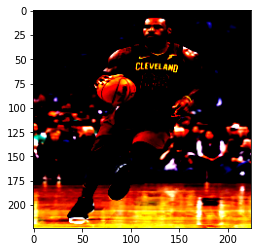

In [10]:
# Displaying resized image. Resized image is for getting prediction from VGG19 model
img, img_number = next(iter(dataloader))
RGB_img = img[0]
plt.imshow(RGB_img.permute(1, 2, 0))

In [24]:
# Extenstion of nn.Module for model
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        
        # get the pretrained VGG19 network
        self.vgg = vgg19(pretrained=True)
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.vgg.features[:36]
        
        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        # forward propagate the image through the CNN part of the model
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)

        # Flattening x so that input is appropriate for classifier layer
        x = x.view((1, -1))

        # getting the class score for input image
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

In [25]:
# initialize the VGG model
vgg = VGG()

# set the evaluation mode
vgg.eval()

# get the image from the dataloader
img, _ = next(iter(dataloader))

# get the most likely prediction of the model
pred = vgg(img)

In [28]:
pip install git+https://github.com/nottombrown/imagenet_stubs

  Cloning https://github.com/nottombrown/imagenet_stubs to /tmp/pip-req-build-7ugcng_i
  Running command git clone -q https://github.com/nottombrown/imagenet_stubs /tmp/pip-req-build-7ugcng_i
  Created wheel for imagenet-stubs: filename=imagenet_stubs-0.0.7-py3-none-any.whl size=794839 sha256=26997155c560e75e8b1d4cb6920e8a33f06943846b30c709a46e03d115faa645
  Stored in directory: /tmp/pip-ephem-wheel-cache-4p3d3shl/wheels/33/0f/5a/c83688c23a05eb9e88527a8944da56dbe007c86f534b0c1dad
Successfully built imagenet-stubs


In [29]:
# Below library from "https://github.com/nottombrown/imagenet-stubs"
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import label_to_name
max_pred_index = torch.argmax(pred)
print('Index of predicted class of ImageNet is:', max_pred_index.item(), ',', 'Class name:', label_to_name(max_pred_index.item()))
print(pred[0][max_pred_index])

Index of predicted class of ImageNet is: 430 , Class name: basketball
tensor(38.3831, grad_fn=<SelectBackward0>)


In [30]:
# compute the gradient of the output with respect to the parameters of the model
pred[:, max_pred_index].backward()

In [31]:
# pull the gradients out of the model
gradients = vgg.get_activations_gradient()
print(gradients.shape)

torch.Size([1, 512, 14, 14])


In [32]:
# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])     # from this we get expression 1 of paper
pooled_gradients_shape = list(pooled_gradients.shape)
print('number of importance weights:', pooled_gradients_shape[0])

number of importance weights: 512


In [38]:
# get the activations of the last convolutional layer and
# detach the output from the computational graph. So that no gradient will be backpropagated along this last convolutional layer.
activations = vgg.get_activations(img).detach()
print('shape of activation map:', activations.shape)

shape of activation map: torch.Size([1, 512, 14, 14])


In [39]:
# weight the channels by corresponding gradients
for i in range(pooled_gradients_shape[0]):
    activations[:, i, :, :] *= pooled_gradients[i]

In [40]:
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()
print(heatmap.shape)

torch.Size([14, 14])


In [41]:
# relu on top of the heatmap
heatmap = np.maximum(heatmap, 0)        # from this we get expression 2 of paper

In [42]:
# normalize the heatmap
heatmap /= torch.max(heatmap)

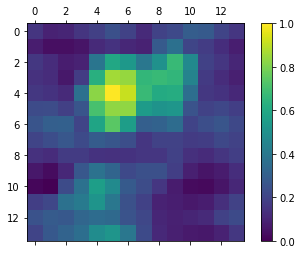

In [43]:
# draw the heatmap
fig, ax = plt.subplots()
cax = ax.matshow(heatmap.squeeze())
fig.colorbar(cax)

In [ ]:
# Creating and saving supperimposed image of original and heatmap
img = cv2.imread(os.path.join(folder,filename))
heatmap = cv2.resize(heatmap.numpy(), (img.shape[1], img.shape[0]), interpolation= cv2.INTER_LINEAR)
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('./Grad-CAM_image.jpg', superimposed_img)

In [ ]:
# Displaying original and superimposed image
from IPython.display import Image
display(Image(os.path.join(folder,filename)))
display(Image('./Grad-CAM_image.jpg'))

## Operations Example

In [ ]:
a = torch.tensor([[[[-2.,10],[4,40],[6,60],[8,80],[10,100]],
                   [[-3,30],[6,60],[9,90],[12,120],[15,150]],
                   [[-4,40],[8,80],[12,120],[16,160],[20,200]],
                   [[-5,50],[10,100],[15,150],[20,200],[25,250]],
                   [[-6,60],[12,120],[18,180],[24,240],[30,300]],
                   [[-7,70],[14,140],[21,210],[28,280],[35,350]]]])
for i in range(list(a.shape)[0]):
    print(a[:, 0, :, :])
print(a.shape)
b = torch.mean(a, dim=1).squeeze()
c = torch.mean(a, dim=1).squeeze()
print(b)
print(c)
b = np.maximum(b, 0)
print(b)
b /= torch.max(b)
print(b)
plt.matshow(b.squeeze())

d = np.uint8(255 * b)
print(d)